# parm@frosst-y to SMIRFF

This notebook provides examples/utility functionality to assist with conversion of parm@frosst or relatives to SMIRFF format. Particularly, Christopher Bayly is generating modified AMBER `frcmod` files where the first entry for each parameter (i.e. `CT-CT-CT`) is replaced by the relevant SMIRKS pattern, for conversion into SMIRFF FFXML format. 

This notebook will:
1. Convert a specified smirks-frcmod file to SMIRFF FFXML
2. Generate (or take in) a set of molecules in OpenEye oemol format
3. Use the SMIRFF `ForceField` class to determine (a) which parameters are used in which molecules; (b) which molecules contain a specified parameter; and (c) which molecules do NOT contain a specified parameter.

Bayly will potentially also update the notebook with visualization for 3(b) and 3(c).


**Authors**:
* David L. Mobley (UCI)


In [3]:
# Imports
from __future__ import print_function
from convert_frcmod import *
import openeye.oechem as oechem
import openeye.oeiupac as oeiupac
import openeye.oeomega as oeomega
import openeye.oedepict as oedepict
from IPython.display import display
from smarty.forcefield import *
from smarty.forcefield_utils import get_molecule_parameterIDs
from smarty.utils import *
% matplotlib inline
import matplotlib
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

In [63]:
def depictAtomByIdx(mol, atomIdxList, supH = False, width=500, height=200):
    molCopy = oechem.OEMol( mol)
    atomBondSet = oechem.OEAtomBondSet()
    for atom in mol.GetAtoms():
        if atom.GetIdx() in atomIdxList:
            atomBondSet.AddAtom( atom)
            for bond in atom.GetBonds():
                nbrAtom = bond.GetNbr(atom)
                nbrIdx = nbrAtom.GetIdx()
                if (nbrIdx in atomIdxList) and nbrIdx>atom.GetIdx():
                    atomBondSet.AddBond( bond)
    from IPython.display import Image
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetDepictOrientation( oedepict.OEDepictOrientation_Horizontal)
    dopt.SetSuppressHydrogens(supH)
    oedepict.OEPrepareDepiction(mol, dopt)
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    disp = oedepict.OE2DMolDisplay(mol, opts)
    aroStyle = oedepict.OEHighlightStyle_Color
    aroColor = oechem.OEColor(oechem.OEGrey)
    oedepict.OEAddHighlighting(disp, aroColor, aroStyle, 
                               oechem.OEIsAromaticAtom(), oechem.OEIsAromaticBond() )
    hstyle = oedepict.OEHighlightStyle_BallAndStick
    hcolor = oechem.OEColor(oechem.OELightGreen)
    oedepict.OEAddHighlighting(disp, hcolor, hstyle, atomBondSet)
    ofs = oechem.oeosstream()
    oedepict.OERenderMolecule(ofs, 'png', disp)
    ofs.flush()
    mol = molCopy
    return Image(data = "".join(ofs.str()))

In [6]:
def getMolParamIDToAtomIndex( oemol, ff):
    """Take an OEMol and a SMIRFF forcefield object and return a dictionary,
    keyed by parameter ID, where each entry is a tuple of
    ( smirks, [[atom1, ... atomN], [atom1, ... atomN]) giving the SMIRKS
    corresponding to that parameter ID and a list of the atom groups in that
    molecule that parameter is applied to.

    Parameters
    ----------
    oemol : OEMol
        OpenEye OEMol with the molecule to investigate.
    ff : ForceField
        SMIRFF ForceField object (obtained from an ffxml via ForceField(ffxml)) containing FF of interest.

    Returns
    -------
    param_usage : dictionary
        Dictionary, keyed by parameter ID, where each entry is a tuple of
        ( smirks, [[atom1, ... atomN], [atom1, ... atomN]) giving the SMIRKS
        corresponding to that parameter ID and a list of the atom groups in
        that molecule that parameter is applied to.

    """
    labels = ff.labelMolecules([oemol])
    param_usage = {}
    for mol_entry in range(len(labels)):
        for force in labels[mol_entry].keys():
            for (atom_indices, pid, smirks) in labels[mol_entry][force]:
                if not pid in param_usage:
                    param_usage[pid] = (smirks, [atom_indices])
                else:
                    param_usage[pid][1].append( atom_indices )

    return param_usage

## 1. Convert specified SMIRKS `frcmod` file to SMIRFF FFXML

In [7]:
# Input and output info
#infile = 'example.frcmod' # smirffish frcmod file to convert
infile = 'smirffishFrcmod.parm99Frosst.txt' # smirffish frcmod file to convert
smirffFilename = 'smirff99Frosst'
ffxmlFile = smirffFilename+'.ffxml'
template = 'template.ffxml' # Template FFXML file without parameters (but with remainder of contents)

In [11]:
# Convert
# Already converted
#convert_frcmod_to_ffxml( infile, template, ffxmlFile)

In [12]:
# Load SMIRFF FFXML
ff = ForceField(ffxmlFile) # We will use this below to access details of parameters

## 2. Generate or take in a set of molecules in OpenEye OEMol format

Here we will take in the ZINC parm@frosst subset from CCL (which is also packaged with SMARTY) and read all the molecules from it.

In [52]:
# Use utils wrapper functions to find the file and read all of the molecules
#oemols = read_molecules( get_data_filename('molecules/zinc-subset-tripos.mol2.gz'))
molecules = read_molecules("/Users/cbanana/Google Drive/RESEARCH/SMIRFF/molecule_sets/updated_DrugBank.mol2.gz")
smiles = set([oechem.OECreateIsoSmiString(mol) for mol in molecules])

oemols = list()
# For use later, generate isomeric SMILES for these so we can easily look up molecules by smiles
isosmiles_to_mol = {}
for smi in smiles:
    mol = oechem.OEMol()
    oechem.OEParseSmiles(mol, smi)
    oechem.OEAddExplicitHydrogens(mol)
    isosmiles_to_mol[smi] = OEMol(mol)
    oemols.append(OEMol(mol))

print("After filtering repeated SMILES there are %i molecules" % len(oemols))

Loading molecules from '/Users/cbanana/Google Drive/RESEARCH/SMIRFF/molecule_sets/updated_DrugBank.mol2.gz'...
6783 molecules read
1.549 s elapsed
After filtering repeated SMILES there are 6635 molecules


## 3. Determine parameter usage in molecules

Here we will use the SMIRFF ForceField class to determine (a) which parameters are used in which molecules; (b) which molecules contain a specified parameter; and (c) which molecules do NOT contain a specified parameter. We begin by just loading the SMIRFF forcefield we generated in section 1.

### 3(a). Determine which parameters are used in which molecules

Here we determine which parameters are actually used in which molecules, and make a couple example plots of the frequency of parameter occurrences for some of our example parameters.

In [53]:
# Use utility function from forcefield_utils to get which parameters are in which molecules
# and which molecules each parameter occurs in. 
# The returns are dictionaries, and molecule identifiers are isomeric smiles generated from the OEMols
# USE TEST FILE CONTAINING GENERICS RATHER THAN OUTPUT FILE FOR NOW
parameters_by_molecule, parameters_by_ID = get_molecule_parameterIDs( oemols, ffxmlFile) #Slow

# Prep for making graphs - determine all parameters used at all
# (TO DO - probably would be useful to determine if any parameters aren't used at all)
param_ids = set()
for key in parameters_by_molecule:
    param_ids = param_ids.union(set(parameters_by_molecule[key]))

# Count occurrences of each parameter
param_id_counts = {}
for param_id in param_ids:
    param_id_counts[param_id] = 0
    for key in parameters_by_molecule:
        param_id_counts[param_id] += parameters_by_molecule[key].count(param_id)

For fun/info, do a quick graph of frequency of occurrence of particular parameters. Here, let's just do bond parameters

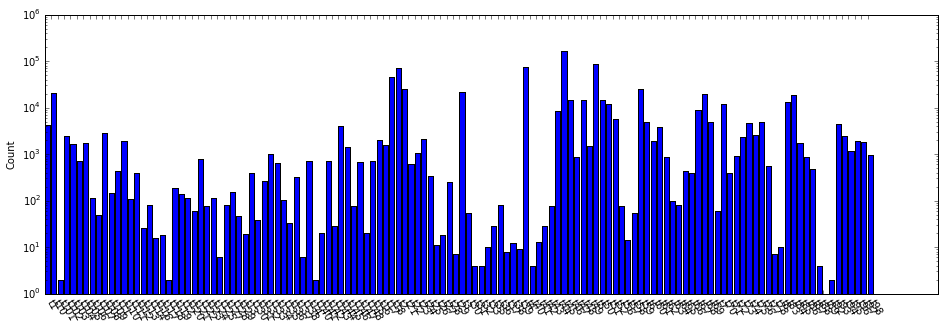

In [54]:
# Graph occurrences of bond parameters
parm_ids = [ pid for pid in param_ids if pid[0]=='t']
parm_ids.sort()
counts_parms = [param_id_counts[parm_id] for parm_id in parm_ids]
#print( parm_ids)
#print( counts_parms)
indices = np.arange(len(parm_ids))
fix, ax = plt.subplots(1,1,figsize=(16,5))
rects2 = ax.bar(indices, counts_parms )
ax.set_ylabel('Count')
ax.set_xticks( indices)
ax.set_xticklabels( parm_ids, rotation=-60, ha='left')
plt.yscale('log', nonposy='clip')
plt.show()

### 3(b)-3(c). Determine which molecules do/do not contain selected parameter

Determine which molecules do and do not contain a specified parameter; give access to isomeric smiles and OEMol for each molecule in each case.

In [55]:
# INPUT: Pick what parameter to look at
parameter_id = 't1' 

# For info, get details of that parameter
params = ff.getParameter(paramID=parameter_id)
print("For parameter %s, the relevant parameters are:" % parameter_id)
print(params)

# Find molecules which do/do not use that parameter
mols_with_param = []
mols_wo_param = []
for isosmi in parameters_by_molecule:
    # Store a tuple of (isomeric smiles, oemol) for each
    if parameter_id in parameters_by_molecule[isosmi]:
        mols_with_param.append( (isosmi, isosmiles_to_mol[isosmi] ))
    else:
        mols_wo_param.append( (isosmi, isosmiles_to_mol[isosmi] ))

print("\nThere are %s molecules containing that parameter and %s which do not, out of %s.\n" % 
      (len(mols_with_param), len(mols_wo_param), len(isosmiles_to_mol)))

# Print first 10 molecules not containing parameter
print("First 10 molecules not containing that parameter:")
for i in range(10):
    print("   %s" % mols_wo_param[i][0])
# Print first 10 molecules containing parameter
print("\nFirst 10 molecules containing that parameter:")
for i in range(10):
    print("   %s" % mols_with_param[i][0])

For parameter t1, the relevant parameters are:
{'phase1': '180.0', 'smirks': '[*:1]~[*:2]~[*:3]~[*:4]', 'k1': '3.50', 'periodicity1': '2', 'id': 't1', 'idivf1': '4'}

There are 813 molecules containing that parameter and 5822 which do not, out of 6635.

First 10 molecules not containing that parameter:
   c1cc(ccc1c2ccc3c(c2)ccc(c3Cl)O)O
   c1cc(cc(c1)C(=N)N)CN2CCN(CC2=O)S(=O)(=O)c3cc4ccc(cc4s3)Cl
   CCCCCCCCC(=O)OCC(CO)OC(=O)CCC
   Cc1cc(=O)oc2c1cccc2
   CN1CCCC(CC1)n2c(=O)c3ccccc3c(n2)Cc4ccc(cc4)Cl
   CCCCN(CCCC)CC(c1cc(cc2c1-c3ccc(cc3C2=Cc4ccc(cc4)Cl)Cl)Cl)O
   c1ccc(cc1)NC(=O)C2CC(=O)N(C2)C3CCCCC3
   c1cc(cc(c1)Cl)C2=C(C(=O)NC2=O)Nc3ccc(c(c3)C(=O)O)Cl
   Cc1ncc(n1C2CC2)c3ccnc(n3)Nc4ccc(cc4)S(=O)(=O)NC
   CC(Cn1cnc2c1ncnc2N)O

First 10 molecules containing that parameter:
   Cc1ccc(c(n1)N)C[n+]2csc(c2C)CCOP(=O)(O)OP(=O)(O)[O-]
   C[n+]1ccccc1C=NO
   c1ccc(c(c1)CNC(=O)Cn2c(cnc(c2=O)NCC(c3cccc[n+]3[O-])(F)F)Cl)F
   CCCCCC(=O)OCC(COP(=O)(O)O)O
   C=C(CCP(=O)(O)O)C=O
   C(P(=O)(O)O)(P(=

In [60]:
def DepictMolWithParam( mol, forcefield, param_ID):
    paramOccDict = getMolParamIDToAtomIndex( mol, forcefield)
    smirks, occIdx = paramOccDict[param_ID]
    for IdxByOccurrence in occIdx:
        image, atomsString = depictAtomByIdx(mol, IdxByOccurrence)
        display( image )
        return atomsString

Selected smiles is Cc1ccc(c(n1)N)C[n+]2csc(c2C)CCOP(=O)(O)OP(=O)(O)[O-]
mol title and NumAtoms:   45


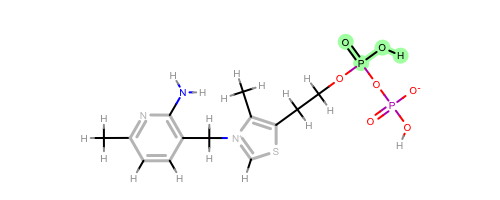

#15~#8~#8~#1~
Selected smiles is C[n+]1ccccc1C=NO
mol title and NumAtoms:   19


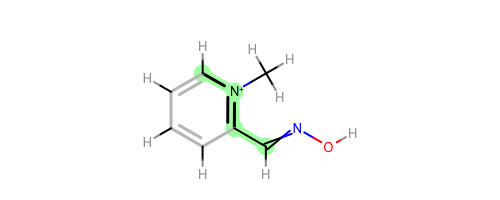

#7~#6~#6~#6~
Selected smiles is c1ccc(c(c1)CNC(=O)Cn2c(cnc(c2=O)NCC(c3cccc[n+]3[O-])(F)F)Cl)F
mol title and NumAtoms:   49


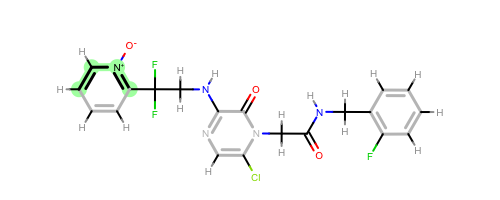

#6~#6~#6~#7~
Selected smiles is CCCCCC(=O)OCC(COP(=O)(O)O)O
mol title and NumAtoms:   36


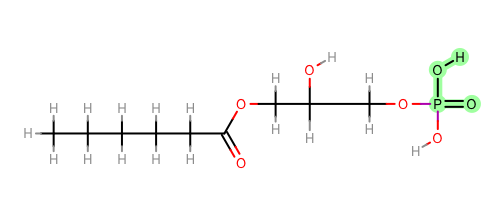

#15~#8~#8~#1~
Selected smiles is C=C(CCP(=O)(O)O)C=O
mol title and NumAtoms:   19


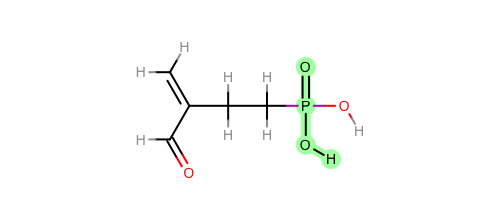

#15~#8~#8~#1~
Selected smiles is C(P(=O)(O)O)(P(=O)(O)O)(Cl)Cl
mol title and NumAtoms:   15


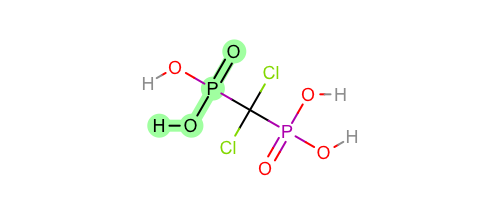

#15~#8~#8~#1~
Selected smiles is c1ccc(cc1)CC(C[N+](=O)[O-])C(=O)O
mol title and NumAtoms:   26


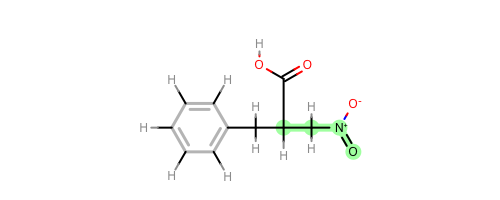

#6~#6~#7~#8~
Selected smiles is c1c(c(nc(=O)n1C2C(C(C(O2)COP(=O)(O)O)O)O)N)Br
mol title and NumAtoms:   35


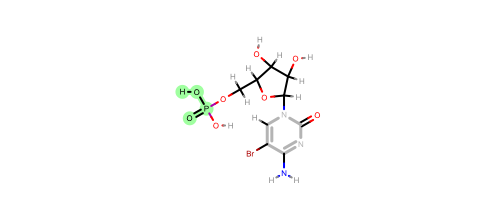

#15~#8~#8~#1~
Selected smiles is CN1CN(c2c1c(=O)[nH]c(n2)N)C3C(C(C(O3)COP(=O)(O)O)O)O
mol title and NumAtoms:   43


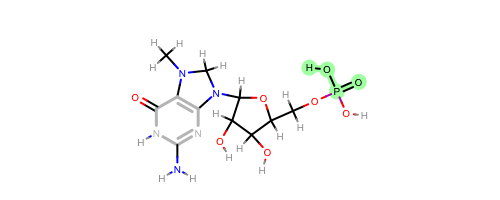

#15~#8~#8~#1~
Selected smiles is CC1=C(C(C(=C(N1)C)P2(=O)OCC(CO2)(C)C)c3cccc(c3)[N+](=O)[O-])C(=O)OCCN(Cc4ccccc4)c5ccccc5
mol title and NumAtoms:   83


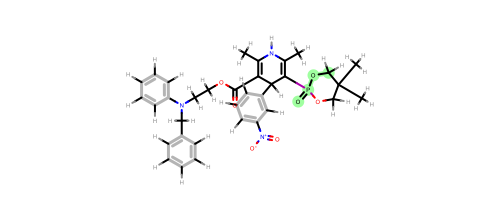

#15~#8~#8~#6~
Selected smiles is c1ccc(cc1)OP(=O)(O)O
mol title and NumAtoms:   18


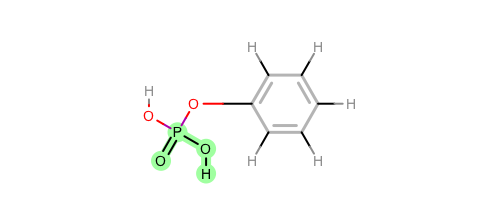

#15~#8~#8~#1~
Selected smiles is Cc1c(c(c(cn1)COP(=O)(O)O)CNC(C=COCCN)C(=O)O)O
mol title and NumAtoms:   48


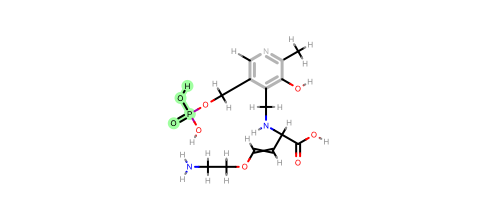

#15~#8~#8~#1~
Selected smiles is c1c(nc2c(=O)[nH]c(nc2n1)N)COP(=O)(O)OP(=O)(O)O
mol title and NumAtoms:   31


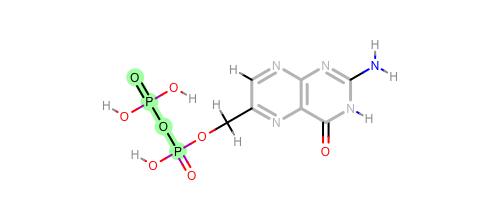

#15~#8~#15~#8~
Selected smiles is C(C(C(C(C(C(=O)O)O)O)O)O)OP(=O)(O)O
mol title and NumAtoms:   30


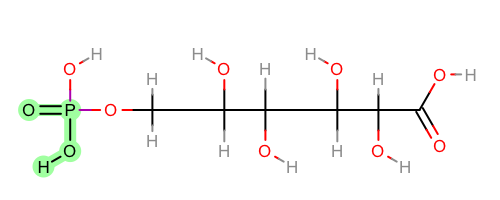

#15~#8~#8~#1~
Selected smiles is CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)n2cnc3c2ncnc3N)O)O)C(C(=O)NCCC(=O)NCCS)O
mol title and NumAtoms:   79


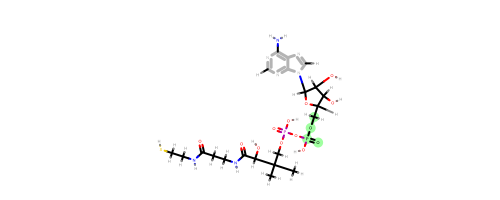

#15~#8~#8~#6~
Selected smiles is C(C1C(C(C(O1)NC(=O)CN)O)O)OP(=O)([O-])[O-]
mol title and NumAtoms:   31


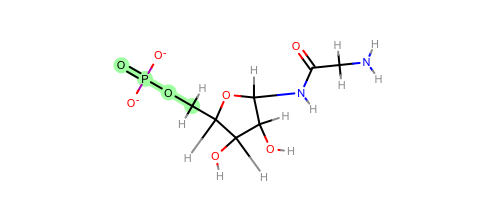

#6~#8~#15~#8~
Selected smiles is CN1CN(c2c1c(=O)[nH]c(n2)N)C3C(C(C(O3)COP(=O)(O)OP(=O)(O)OP(=O)(O)O)O)O
mol title and NumAtoms:   53


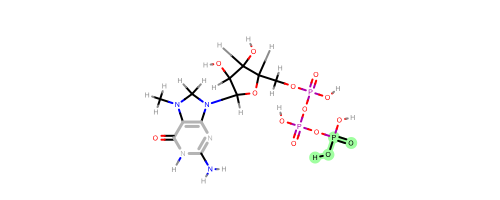

#15~#8~#8~#1~
Selected smiles is CC1(C(=C(C([N+]1=O)(C)C)c2ccccc2)CSSCC(C(=O)O)N)C
mol title and NumAtoms:   50


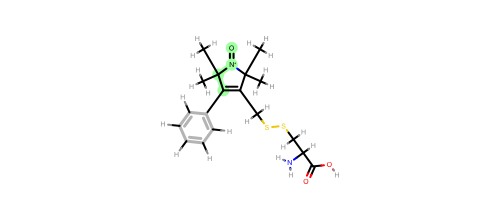

#6~#6~#7~#8~
Selected smiles is C(CC(C(=O)O)N)CNC(=O)CP(=O)(O)O
mol title and NumAtoms:   31


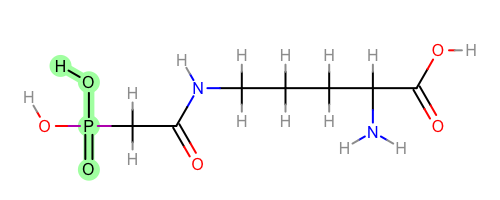

#15~#8~#8~#1~
Selected smiles is CNC1=C2=C(=C(N=N2)C3C(C(C(O3)CO)O)O)N=CN1
mol title and NumAtoms:   35


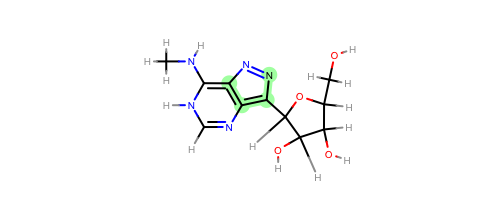

#6~#6~#6~#7~


In [61]:
limit = len(mols_with_param)
upperlimit = 20
if limit>upperlimit:
    limit = upperlimit
for idx in range(0, limit):
    smiles = mols_with_param[idx][0]
    mol = mols_with_param[idx][1]
    print('Selected smiles is %s' % smiles)
    print( 'mol title and NumAtoms: ', mol.GetTitle(), mol.NumAtoms() )
    print(DepictMolWithParam( mol, ff, parameter_id))